# Figure 3D-G: Visualization of discontinuous transcription sites

In [2]:
%cd ~/p/npworks/20200222-Vero-SCV2/

/blaze/hyeshik/p/npworks/20200222-Vero-SCV2


Load the color coding based on [yeun-opencolors](https://yeun.github.io/open-color/). 

In [3]:
orfcolors = pd.read_csv('colorcode-rainbow.txt', sep=' ', names=['orf', 'color'], index_col=0)['color'].to_dict()
orfcolors

{'ORF1a': '#c5d9ea',
 'ORF1b': '#e8d2c4',
 'S': '#82c91e',
 'ORF3a': '#3bc9db',
 'E': '#228be6',
 'M': '#9fb1fc',
 'ORF6': '#7950f2',
 'ORF7a': '#da77f2',
 'ORF7b': '#e64980',
 'ORF8': '#fd7e14',
 'N': '#ffd43b'}

In [4]:
annotations = pd.read_csv('refs/SARS-CoV-2-annotations.gff', sep='\t',
                         names=['chrom', 'type', 'name', 'start', 'end', '_x', '_y', '_z'])
annotations['start'] -= 1

# Non Leader
#cdsanno = annotations[(annotations['type'] == 'CDS') &
#                      (~annotations['name'].isin(['ORF10', 'nsp11', 'frameshift']))]

# Leader
cdsanno = annotations[(annotations['type'] == 'CDS') &
                      (~annotations['name'].isin(['ORF10', 'nsp1', 'frameshift'])) &
                      (~annotations['name'].apply(lambda x: x.startswith('nsp')))]
cdsanno = pd.concat([
    cdsanno,
    pd.DataFrame([
        pd.Series(['chrSCV', 'CDS', 'ORF1a', 265, 13467, 0.0, '.', '.'], index=cdsanno.columns),
        pd.Series(['chrSCV', 'CDS', 'ORF1b', 13467, 21552, 0.0, '.', '.'], index=cdsanno.columns),
    ])
]).sort_values(by='start').reset_index(drop=True).iloc[:, :5]

cdsanno

,chrom,type,name,start,end
0,chrSCV,CDS,ORF1a,265,13467
1,chrSCV,CDS,ORF1b,13467,21552
2,chrSCV,CDS,S,21562,25384
3,chrSCV,CDS,ORF3a,25392,26220
4,chrSCV,CDS,E,26244,26472
5,chrSCV,CDS,M,26522,27191
6,chrSCV,CDS,ORF6,27201,27387
7,chrSCV,CDS,ORF7a,27393,27759
8,chrSCV,CDS,ORF7b,27755,27887
9,chrSCV,CDS,ORF8,27893,28259


In [5]:
largedels_mgi = \
    pd.read_csv('mgiseq/jumpstats/VeroSCV2.jumps.txt.gz',
               compression='gzip', names=['j5', 'j3', 'count'], sep='\t')

In [6]:
len(largedels_mgi)

224610

In [7]:
from Bio import SeqIO, Seq
covseq = str(next(SeqIO.parse('/blaze/hyeshik/p/npworks/20200222-Vero-SCV2/refs/SARS-CoV-2.fa','fasta')).seq)

In [8]:
SNEEKSIZE = 12

largedel_anno = []

for _, row in largedels_mgi.iterrows():
    seqleft = covseq[:row.j5]
    seqright = covseq[row.j3:]
    seqrecomb = seqleft + seqright

    if 'ATG' in seqrecomb:
        # calculate start codon positions
        startpos_recomb = seqrecomb.find('ATG')
        if startpos_recomb < row.j5:
            startpos = startpos_recomb
        else:
            startpos = startpos_recomb - row.j5 + row.j3

        # calculate protein product size
        orfcandseq = seqrecomb[startpos_recomb:]
        if len(orfcandseq) % 3 > 0:
            orfcandseq += 'N' * (3 - len(orfcandseq) % 3)

        translation = Seq.Seq(orfcandseq).translate().split('*')[0]
        #if row['name'] == 'j2':
        #    print(Seq(orfcandseq).translate())
        product_size = len(translation)
    else:
        startpos_recomb = -1
        startpos = -1
        product_size = 0
        translation = ''

    #recombseq = covseq[row.j5 - SNEEKSIZE:row.j5].lower() + (
    #    covseq[row.j3:row.j3 + SNEEKSIZE])

    largedel_anno.append([row['j5'], row['j3'], row['count'],
                          startpos, product_size])

largedel_anno = pd.DataFrame(largedel_anno, columns=[
    'j5', 'j3', 'count', 'startpos', 'productsize'])
largedel_anno.head()

,j5,j3,count,startpos,productsize
0,25,26863,1,26895,4
1,25,29477,1,29503,9
2,34,25610,1,25717,2
3,36,18028,1,18046,1
4,36,29661,1,29770,11


In [9]:
len(largedel_anno)

224610

In [10]:
largedel_anno = largedel_anno.sort_values(by='count', ascending=False).reset_index(drop=True)
largedel_anno.head()

,j5,j3,count,startpos,productsize
0,64,28254,7012631,28273,419
1,65,21551,1117576,21562,1273
2,26256,26283,800532,106,9
3,66,27384,688112,27393,121
4,65,25380,618367,25392,275


In [11]:
lda_mg = \
largedel_anno.groupby('startpos').agg({'count': 'sum', 'j5': 'first', 'j3': 'first',
                                      'productsize': 'first'}).sort_values(by='count',
                                                                          ascending=False)

In [12]:
lda_mg.head(20)

,count,j5,j3,productsize
startpos,,,,
28273,7085093,64,28254,419
106,1573395,26256,26283,9
21562,1139782,65,21551,1273
27393,700621,66,27384,121
25392,618913,65,25380,275
27893,233652,65,27883,121
26522,219132,64,26467,222
26244,150031,69,26236,75
27201,38936,69,27040,61


In [13]:
(largedel_anno['j3'] - largedel_anno['j5']).min()

20

In [14]:
BLACKLIST = [
    [26256, 26283], # mixed substrain with partial deletion in genomic RNA
]

for blkstart, blkend in BLACKLIST:
    largedel_anno = largedel_anno[~((largedel_anno['j5'] == blkstart) &
                                    (largedel_anno['j3'] == blkend))]
largedel_anno['count'].sum()

11019906

In [15]:
CANONICAL_START = 59 # 0-based, inc
CANONICAL_END = 80 # 0-based, noninc

is_cano = largedel_anno['j5'].between(CANONICAL_START, CANONICAL_END-1)
ld_cano = largedel_anno[is_cano]
ld_noncano = largedel_anno[~is_cano]

ld_cano['count'].sum(), ld_noncano['count'].sum()

(10241961, 777945)

In [16]:
can_prod = pd.merge(ld_cano, cdsanno, left_on='startpos', right_on='start')
can_prod['count'].sum()

10192205

In [17]:
can_prod.groupby('name').agg({'count': 'sum'}).sort_values(by='count', ascending=False)

,count
name,
N,7084788
S,1138547
ORF7a,700590
ORF3a,618897
ORF8,233622
M,218170
E,150030
ORF6,38908
ORF7b,8641


In [18]:
can_nonprod = pd.merge(ld_cano, cdsanno, left_on='startpos', right_on='start', how='left')
can_nonprod = can_nonprod[can_nonprod['name'].isnull()]

In [19]:
can_nonprod['count'].sum()

49756

In [20]:
can_nonprod

,j5,j3,count,startpos,productsize,chrom,type,name,start,end
13,71,27761,8568,27824,20,NaN,NaN,NaN,NaN,NaN
15,68,15776,6103,15811,28,NaN,NaN,NaN,NaN,NaN
16,70,27760,5982,69,4,NaN,NaN,NaN,NaN,NaN
22,68,29153,1216,29221,103,NaN,NaN,NaN,NaN,NaN
24,74,21057,990,21070,23,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2937,60,29673,1,29770,11,NaN,NaN,NaN,NaN,NaN
2939,61,18919,1,18940,2,NaN,NaN,NaN,NaN,NaN
2940,61,23651,1,23752,543,NaN,NaN,NaN,NaN,NaN
2942,61,26820,1,26846,114,NaN,NaN,NaN,NaN,NaN


In [21]:
def measure_translation_length(startpos):
    seq = covseq[startpos:]
    if len(seq) % 3 > 0:
        seq += 'N' * (3 - (len(seq) % 3))
    return len(Seq.Seq(seq).translate().split('*')[0])

def annotate_orf(startpos):
    ovl_cds = (
        cdsanno[(cdsanno['start'] <= startpos) &
                (startpos < cdsanno['end'])])

    if len(ovl_cds) >= 2:
        ovl_cds = ovl_cds[~ovl_cds['name'].apply(lambda x: x.startswith('nsp') or x == 'ORF7b')]
        if len(ovl_cds) != 1:
            raise ValueError("Unresolvable conflict: " + ' '.join(ovl_cds['name']))
    elif len(ovl_cds) < 1:
        # Downstream
        nextcdses = cdsanno[cdsanno['start'] >= startpos]
        if len(nextcdses) == 0:
            return 'noORF', None, None
        nextcds = nextcdses.iloc[0]
        offset = nextcds['start'] - startpos
        if offset % 3 == 0:
            return 'N-term addition', nextcds['name'], offset // 3
        else:
            return 'frameshift,5p', nextcds['name'], offset
    
    # Single-hit within a known CDS
    ovl_cds = ovl_cds.iloc[0]
    offset = startpos - ovl_cds['start']
    if offset % 3 == 0:
        return 'N-term trunc', ovl_cds['name'], offset // 3
    
    neworflength = measure_translation_length(startpos)
    return 'frameshift,mid', ovl_cds['name'], neworflength

annotate_orf(27827)

('N-term trunc', 'ORF7b', 24)

### Test if startcodon is generated by the fusion

In [22]:
def test_startcodon_fusiogenesis(row):
    fuse = covseq[int(row['j5'])-2:int(row['j5'])] + covseq[int(row['j3']):int(row['j3'])+2]
    if 'ATG' in fuse:
        position = fuse.index('ATG') # 0 or 1
        return 2-position
    else:
        return -1
fusestart_pos = can_nonprod.apply(test_startcodon_fusiogenesis, axis=1)
fusestart_pos

13     -1
15     -1
16      1
22     -1
24     -1
       ..
2937   -1
2939   -1
2940   -1
2942   -1
2943   -1
Length: 2489, dtype: int64

In [23]:
fusestarted = can_nonprod[fusestart_pos >= 0].copy()
fusestarted['startpos_byfusion'] = fusestarted['j3'] - fusestart_pos[fusestart_pos >= 0]
remaining = can_nonprod[fusestart_pos < 0]
fusestarted['count'].sum(), remaining['count'].sum()

(6437, 43319)

In [24]:
fusestarted_annotation = fusestarted['startpos_byfusion'].apply(annotate_orf)
fusestarted_annotation = fusestarted_annotation.apply(pd.Series)
fusestarted_annotation.columns = ['evtype', 'evrelorf', 'evsize']
fusestarted = pd.concat([
    fusestarted,
    fusestarted_annotation], axis=1)
fusestarted.head()

,j5,j3,count,startpos,productsize,chrom,type,name,start,end,startpos_byfusion,evtype,evrelorf,evsize
16,70,27760,5982,69,4,NaN,NaN,NaN,NaN,NaN,27759,"frameshift,mid",ORF7b,4.0
64,70,2793,217,69,25,NaN,NaN,NaN,NaN,NaN,2792,"frameshift,mid",ORF1a,25.0
129,70,28952,81,69,193,NaN,NaN,NaN,NaN,NaN,28951,N-term trunc,N,226.0
188,70,26929,41,69,3,NaN,NaN,NaN,NaN,NaN,26928,"frameshift,mid",M,3.0
204,70,20285,36,69,5,NaN,NaN,NaN,NaN,NaN,20284,"frameshift,mid",ORF1b,5.0


In [25]:
fanno = fusestarted.groupby(['evtype', 'evrelorf']).agg({'count': 'sum'})
print(fanno['count'].sum())
fanno

6435


count
evtype          evrelorf       
N-term addition M             3
N-term trunc    M             1
                N            83
                ORF1a         1
                ORF3a         1
frameshift,5p   M             2
frameshift,mid  E             1
                M            54
                N             4
                ORF1a       223
                ORF1b        40
                ORF3a         5
                ORF7a         1
                ORF7b      6007
                ORF8          1
                S             8

In [26]:
fusestarted['count'].sum()

6437

In [27]:
fusestarted.groupby('evtype').agg({'count': 'sum'})

,count
evtype,
N-term addition,3
N-term trunc,86
"frameshift,5p",2
"frameshift,mid",6344
noORF,2


In [28]:
annotation = remaining['startpos'].apply(annotate_orf)
annotation = annotation.apply(pd.Series)
annotation.columns = ['evtype', 'evrelorf', 'evsize']
remaining = pd.concat([
    remaining, annotation], axis=1)
remaining.head()

,j5,j3,count,startpos,productsize,chrom,type,name,start,end,evtype,evrelorf,evsize
13,71,27761,8568,27824,20,NaN,NaN,NaN,NaN,NaN,N-term trunc,ORF7b,23.0
15,68,15776,6103,15811,28,NaN,NaN,NaN,NaN,NaN,"frameshift,mid",ORF1b,28.0
22,68,29153,1216,29221,103,NaN,NaN,NaN,NaN,NaN,N-term trunc,N,316.0
24,74,21057,990,21070,23,NaN,NaN,NaN,NaN,NaN,"frameshift,mid",ORF1b,23.0
27,68,29111,818,29221,103,NaN,NaN,NaN,NaN,NaN,N-term trunc,N,316.0


In [29]:
remaining['count'].sum()

43319

In [30]:
remaining

,j5,j3,count,startpos,productsize,chrom,type,name,start,end,evtype,evrelorf,evsize
13,71,27761,8568,27824,20,NaN,NaN,NaN,NaN,NaN,N-term trunc,ORF7b,23.0
15,68,15776,6103,15811,28,NaN,NaN,NaN,NaN,NaN,"frameshift,mid",ORF1b,28.0
22,68,29153,1216,29221,103,NaN,NaN,NaN,NaN,NaN,N-term trunc,N,316.0
24,74,21057,990,21070,23,NaN,NaN,NaN,NaN,NaN,"frameshift,mid",ORF1b,23.0
27,68,29111,818,29221,103,NaN,NaN,NaN,NaN,NaN,N-term trunc,N,316.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937,60,29673,1,29770,11,NaN,NaN,NaN,NaN,NaN,noORF,None,NaN
2939,61,18919,1,18940,2,NaN,NaN,NaN,NaN,NaN,"frameshift,mid",ORF1b,2.0
2940,61,23651,1,23752,543,NaN,NaN,NaN,NaN,NaN,N-term trunc,S,730.0
2942,61,26820,1,26846,114,NaN,NaN,NaN,NaN,NaN,N-term trunc,M,108.0


In [31]:
remaining.groupby('evtype').agg({'count': 'sum'})

,count
evtype,
N-term trunc,16024
"frameshift,5p",87
"frameshift,mid",26751
noORF,457


In [32]:
remaining.groupby(['evtype', 'evrelorf']).agg({'count': 'sum'})

count
evtype         evrelorf       
N-term trunc   M           170
               N          4404
               ORF1a       590
               ORF1b       366
               ORF3a       451
               ORF6        116
               ORF7b      9751
               S           176
frameshift,5p  E            87
frameshift,mid M           809
               N          3269
               ORF1a      1898
               ORF1b     10747
               ORF3a      1076
               ORF6        569
               ORF7b       194
               ORF8        984
               S          7205

In [33]:
remaining[remaining['evtype'] == 'frameshift,mid'].head(30)

,j5,j3,count,startpos,productsize,chrom,type,name,start,end,evtype,evrelorf,evsize
15,68,15776,6103,15811,28,NaN,NaN,NaN,NaN,NaN,"frameshift,mid",ORF1b,28.0
24,74,21057,990,21070,23,NaN,NaN,NaN,NaN,NaN,"frameshift,mid",ORF1b,23.0
28,67,24776,728,24809,21,NaN,NaN,NaN,NaN,NaN,"frameshift,mid",S,21.0
29,70,22944,703,23003,29,NaN,NaN,NaN,NaN,NaN,"frameshift,mid",S,29.0
30,70,22276,699,22358,11,NaN,NaN,NaN,NaN,NaN,"frameshift,mid",S,11.0
31,68,28282,686,28283,97,NaN,NaN,NaN,NaN,NaN,"frameshift,mid",N,97.0
33,67,26865,606,26895,4,NaN,NaN,NaN,NaN,NaN,"frameshift,mid",M,4.0
34,70,22501,580,22613,36,NaN,NaN,NaN,NaN,NaN,"frameshift,mid",S,36.0
37,69,24890,553,24890,19,NaN,NaN,NaN,NaN,NaN,"frameshift,mid",S,19.0
38,70,29002,514,29078,1,NaN,NaN,NaN,NaN,NaN,"frameshift,mid",N,1.0


In [34]:
partialS = str(Seq.Seq(covseq[24776:][33:]).translate().split('*')[0])

In [35]:
fullS = str(Seq.Seq(covseq[21562:]).translate().split('*')[0])

/blaze/hyeshik/conda/envs/lab/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


In [36]:
fullS.count('M') / len(fullS)

0.010997643362136685

In [37]:
covseq[21562:25384].count('ATG')

78

In [38]:
16/78

0.20512820512820512

## Canonical productive

In [39]:
can_prod = pd.merge(ld_cano, cdsanno, left_on='startpos', right_on='start', how='left')
can_prod = can_prod[can_prod['name'].notnull()]
can_prod

,j5,j3,count,startpos,productsize,chrom,type,name,start,end
0,64,28254,7012631,28273,419,chrSCV,CDS,N,28273.0,29533.0
1,65,21551,1117576,21562,1273,chrSCV,CDS,S,21562.0,25384.0
2,66,27384,688112,27393,121,chrSCV,CDS,ORF7a,27393.0,27759.0
3,65,25380,618367,25392,275,chrSCV,CDS,ORF3a,25392.0,26220.0
4,65,27883,229749,27893,121,chrSCV,CDS,ORF8,27893.0,28259.0
...,...,...,...,...,...,...,...,...,...,...
2932,60,28247,1,28273,419,chrSCV,CDS,N,28273.0,29533.0
2933,60,28253,1,28273,419,chrSCV,CDS,N,28273.0,29533.0
2938,61,27692,1,27755,43,chrSCV,CDS,ORF7b,27755.0,27887.0
2941,61,26461,1,26522,222,chrSCV,CDS,M,26522.0,27191.0


## Non-canonical

In [40]:
ld_noncano['count'].sum()

777945

In [41]:
delsize = ld_noncano['j3'] - ld_noncano['j5']
nc_distal = ld_noncano[delsize >= 5000].copy()
nc_proximal = ld_noncano[delsize < 5000].copy()
nc_distal['count'].sum(), nc_proximal['count'].sum()

(459910, 318035)

In [42]:
def measure_translation_length_by_seq(seq):
    if len(seq) % 3 > 0:
        seq += 'N' * (3 - (len(seq) % 3))
    return len(Seq.Seq(seq).translate().split('*')[0])

def annotate_orf_by_joint_position(row):
    j5, j3 = row['j5'], row['j3']
    j5_1 = j5 - 1 # last nucleotide in the 5' fragment

    ovl_cds5 = (
        cdsanno[(cdsanno['start'] <= j5_1) & (j5_1 < cdsanno['end'])])

    if len(ovl_cds5) >= 2:
        ovl_cds5 = ovl_cds5[~ovl_cds5['name'].apply(lambda x: x.startswith('nsp') or x == 'ORF7b')]
        if len(ovl_cds5) != 1:
            raise ValueError("Unresolvable conflict: {} ".format(j5_1) + ' '.join(ovl_cds5['name']))
    elif len(ovl_cds5) < 1:
        # j5 is in the middle of non-coding region. Use the downstream of j3
        nextcdses = cdsanno[cdsanno['start'] >= j3]
        if len(nextcdses) == 0:
            return 'no-orf', None, None
        nextcds = nextcdses.iloc[0]
        return 'may-translate', nextcds['name'], nextcds['start'] - j3
    
    # Single-hit within a known CDS
    ovl_cds5 = ovl_cds5.iloc[0]
    offset5 = j5 - ovl_cds5['start']
    seqleft = covseq[ovl_cds5['start']:j5]
    seqright = covseq[j3:]
    frame5 = len(seqleft) % 3

    # Find 3' position identity
    ovl_cds3 = (
        cdsanno[(cdsanno['start'] <= j3) & (j3 < cdsanno['end'])])
    if len(ovl_cds3) >= 2:
        ovl_cds3 = ovl_cds3[~ovl_cds3['name'].apply(lambda x: x.startswith('nsp') or x == 'ORF7b')]
        if len(ovl_cds3) != 1:
            raise ValueError("Unresolvable conflict: {} ".format(j3) + ' '.join(ovl_cds3['name']))
    elif len(ovl_cds3) < 1:
        # j5 is in ORF, j3 is not in ORF.
        product_len = measure_translation_length_by_seq(seqleft + seqright)

        nextcdses = cdsanno[cdsanno['start'] >= j3]
        if len(nextcdses) > 0:
            nextcds = nextcdses.iloc[0]
            nextstartoffset = nextcds['start'] - j3
            if product_len > (offset5 + nextstartoffset) / 3:
                return 'mid-utr-inserted-fusion', '{}-{}'.format(ovl_cds5['name'], nextcds['name']), (offset5/3, nextstartoffset/3)

        return 'C-term-trunc-and-extension-by-UTR', ovl_cds5['name'], (offset5/3, product_len)

    # Single-hit within a known CDS for 3' site too.
    ovl_cds3 = ovl_cds3.iloc[0]
    offset3 = j3 - ovl_cds3['start']
    remaining3 = ovl_cds3['end'] - j3
    frame3 = offset3 % 3
    
    if frame5 == frame3:
        return 'in-frame-fusion-orf', '{}-{}'.format(ovl_cds5['name'], ovl_cds3['name']), (offset5/3, remaining3/3)

    product_len = measure_translation_length_by_seq(seqleft + seqright)
    return 'frameshift-fusion-orf', '{}-{}'.format(ovl_cds5['name'], ovl_cds3['name']), (offset5/3, product_len)

annotate_orf_by_joint_position(nc_distal.iloc[0])

('frameshift-fusion-orf', 'ORF1a-N', (529.3333333333334, 539))

In [43]:
annotation = nc_distal.apply(annotate_orf_by_joint_position, axis=1)
annotation = annotation.apply(pd.Series)
annotation.columns = ['evtype', 'evrelorf', 'evsize']
nc_distal = pd.concat([
    nc_distal, annotation], axis=1)
nc_distal.head()

,j5,j3,count,startpos,productsize,evtype,evrelorf,evsize
51,1853,29475,1013,106,9,frameshift-fusion-orf,ORF1a-N,"(529.3333333333334, 539)"
60,83,21562,863,21562,1273,may-translate,S,0
74,21571,27809,669,106,9,in-frame-fusion-orf,S-ORF7b,"(3.0, 26.0)"
75,82,26276,669,26522,222,may-translate,M,246
77,21569,27807,656,106,9,in-frame-fusion-orf,S-ORF7b,"(2.3333333333333335, 26.666666666666668)"


In [44]:
nc_distal.groupby('evtype').agg({'count': 'sum'})

,count
evtype,
C-term-trunc-and-extension-by-UTR,5741
frameshift-fusion-orf,276665
in-frame-fusion-orf,168839
may-translate,4413
mid-utr-inserted-fusion,3514
no-orf,738


In [46]:
nc_distal.groupby(['evtype', 'evrelorf']).agg({'count': 'sum'}).to_excel('figure-outputs/nc-distal.xlsx')

In [47]:
annotation = nc_proximal.apply(annotate_orf_by_joint_position, axis=1)
annotation = annotation.apply(pd.Series)
annotation.columns = ['evtype', 'evrelorf', 'evsize']
nc_proximal = pd.concat([
    nc_proximal, annotation], axis=1)
nc_proximal.head()

,j5,j3,count,startpos,productsize,evtype,evrelorf,evsize
10,27886,27908,26861,106,9,frameshift-fusion-orf,ORF7b-ORF8,"(43.666666666666664, 45)"
13,26249,26276,11161,106,9,in-frame-fusion-orf,E-E,"(1.6666666666666667, 65.33333333333333)"
17,26779,26816,7492,106,9,frameshift-fusion-orf,M-M,"(85.66666666666667, 116)"
18,26786,26820,6663,106,9,frameshift-fusion-orf,M-M,"(88.0, 117)"
22,29069,29093,5466,106,9,in-frame-fusion-orf,N-N,"(265.3333333333333, 146.66666666666666)"


In [48]:
nc_proximal.groupby('evtype').agg({'count': 'sum'})

,count
evtype,
C-term-trunc-and-extension-by-UTR,11471
frameshift-fusion-orf,165785
in-frame-fusion-orf,110718
may-translate,6025
mid-utr-inserted-fusion,942
no-orf,23094


In [49]:
nc_proximal.groupby(['evtype', 'evrelorf']).agg({'count': 'sum'}).to_excel('figure-outputs/nc-proximal.xlsx')

## Massive sashimi plots

In [50]:
from matplotlib.patches import Rectangle

In [51]:
def common_tune(ax):
    ax.set_xlim(-.1, 29950)
    ax.set_ylim(-12, 12)

    for spname in 'top left right'.split():
        ax.spines[spname].set_visible(False)
    plt.setp(ax.get_yticklines(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)

In [52]:
ANCHOR_TOP = 1.5
ANCHOR_BOTTOM = -1.5
APEX_TOP = 9
APEX_BOTTOM = -9

def draw_bar(ax):
    for _, row in cdsanno.iterrows():
        if row['name'].startswith('nsp'):
            continue
        rect = Rectangle((row['start'], ANCHOR_BOTTOM), row['end'] - row['start'], ANCHOR_TOP-ANCHOR_BOTTOM, fc=orfcolors[row['name']])
        ax.add_patch(rect)

    rect = Rectangle((0, ANCHOR_BOTTOM), 265, ANCHOR_TOP-ANCHOR_BOTTOM, fc='#505050')
    ax.add_patch(rect)
    rect = Rectangle((265, ANCHOR_BOTTOM), 13441-265, ANCHOR_TOP-ANCHOR_BOTTOM, fc='#c5d9ea')
    ax.add_patch(rect)
    rect = Rectangle((13441, ANCHOR_BOTTOM), 21552-13441, ANCHOR_TOP-ANCHOR_BOTTOM, fc='#e8d2c4')
    ax.add_patch(rect)
    rect = Rectangle((29533, ANCHOR_BOTTOM), 29930-29533, ANCHOR_TOP-ANCHOR_BOTTOM, fc='#d0d0d0')
    ax.add_patch(rect)

In [53]:
def draw_junction(ax, start, end, top, height_coef=1, **kwds):
    distance = (end - start)

    height = max(1, height_coef * .015 * distance ** .6)
    curve = 3 * height ** .5
    pleft = start + distance / curve
    pmid = start + distance / 2
    pright = start + distance * (curve - 1) / curve
    anchor = ANCHOR_TOP if top else ANCHOR_BOTTOM
    apex = ANCHOR_TOP+height if top else ANCHOR_BOTTOM-height
    
    if 'edgecolor' in kwds:
        pass
    elif top:
        kwds['edgecolor'] = '#364fc7'
    else:
        kwds['edgecolor'] = '#c92a2a'
    pp1 = mpatches.PathPatch(
        Path([(start, anchor), (pleft, apex), (pmid, apex), (pright, apex), (end, anchor)],
             [Path.MOVETO, Path.CURVE3, Path.CURVE3, Path.CURVE3, Path.MOVETO]),
        fc="none", transform=ax.transData, **kwds)
    ax.add_patch(pp1)

In [54]:
import matplotlib.path as mpath
import matplotlib.patches as mpatches
Path = mpath.Path

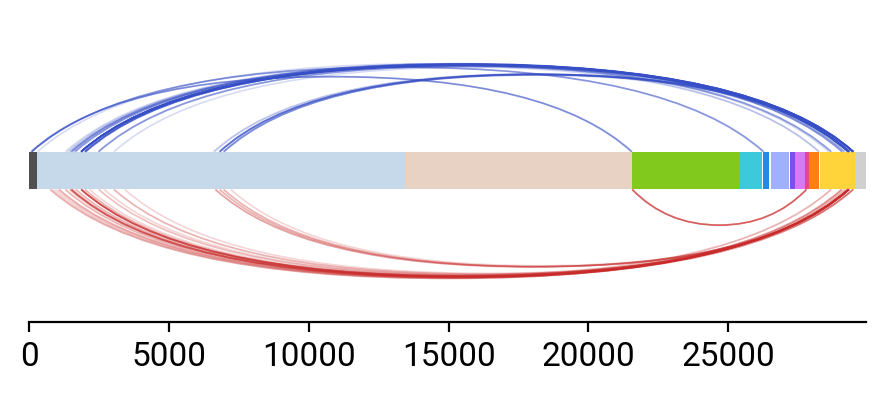

In [56]:
ALPHA_MAP = [
    [1000, 1.0],
    [500, 0.5],
    [200, 0.3],
    [100, 0.2],
    [50, 0.1],
    [0, 0.01]
]
def calc_alpha(jnc):
    for mincnt, alpha in ALPHA_MAP:
        if jnc['count'] >= mincnt:
            return alpha
    return 0

fig, ax = plt.subplots(1, 1, figsize=(5.4, 2))

draw_bar(ax)

for _, jnc in nc_distal.iloc[:100].iterrows():
    alpha = calc_alpha(jnc)
    draw_junction(ax, jnc.j5, jnc.j3, top=('in-frame' not in jnc.evtype), alpha=alpha,
                  lw=.6)
    
common_tune(ax)
plt.savefig('figure-outputs/plot-distal.pdf')

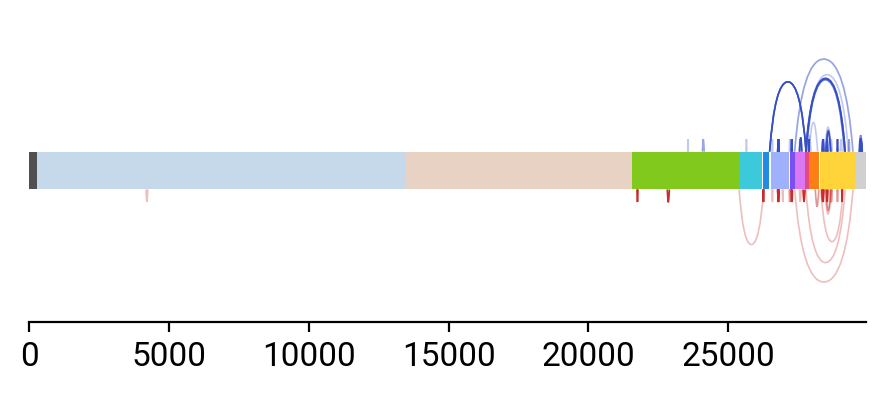

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(5.4, 2))

draw_bar(ax)

for _, jnc in nc_proximal.iloc[:100].iterrows():
    alpha = calc_alpha(jnc)
    draw_junction(ax, jnc.j5, jnc.j3, top=('in-frame' not in jnc.evtype),
                  alpha=alpha, height_coef=5, lw=.6)
    
common_tune(ax)
plt.savefig('figure-outputs/plot-proximal.pdf')

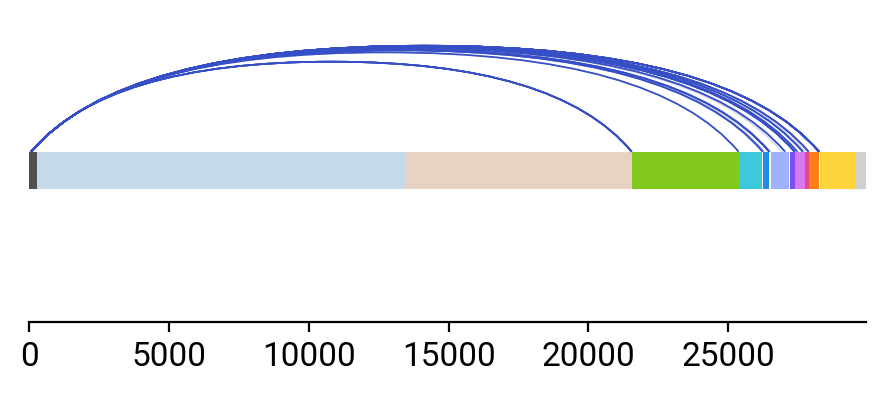

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(5.4, 2))

draw_bar(ax)

for _, jnc in can_prod.iloc[:100].iterrows():
    alpha = calc_alpha(jnc)
    draw_junction(ax, jnc.j5, jnc.j3, top=True,
                  alpha=alpha, height_coef=1.2, lw=.6)
    
common_tune(ax)
plt.savefig('figure-outputs/plot-canonical.pdf')

In [59]:
fuse_inframe = fusestarted[fusestarted['evtype'].isin(['N-term addition'])]['j5 j3 count'.split()]
fuse_outframe = fusestarted[~fusestarted['evtype'].isin(['N-term addition'])]['j5 j3 count'.split()]

In [60]:
rem_inframe = remaining[remaining['evtype'].isin(['N-term trunc'])]['j5 j3 count'.split()]
rem_outframe = remaining[~remaining['evtype'].isin(['N-term trunc'])]['j5 j3 count'.split()]

In [61]:
can_inframe = pd.concat([fuse_inframe, rem_inframe]).sort_values(by='count', ascending=False)
can_outframe = pd.concat([fuse_outframe, rem_outframe]).sort_values(by='count', ascending=False)

In [62]:
can_inframe

,j5,j3,count
13,71,27761,8568
22,68,29153,1216
27,68,29111,818
32,75,28964,622
47,78,25393,355
...,...,...,...
1831,69,17516,1
1830,69,20587,1
1819,69,17951,1
1815,69,17459,1


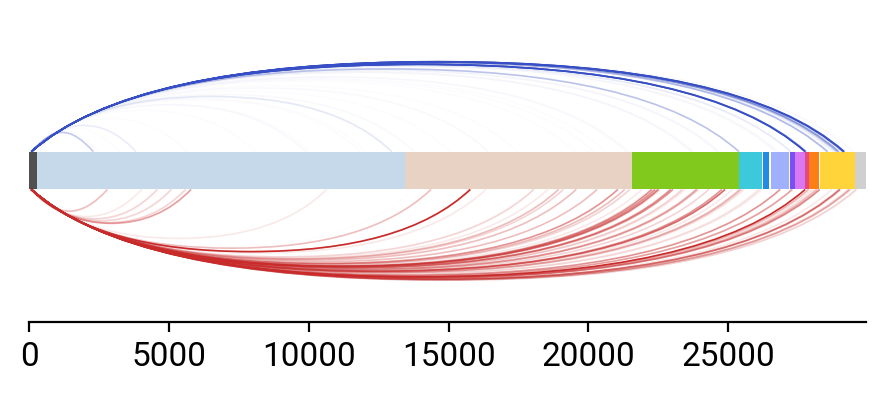

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(5.4, 2))

draw_bar(ax)

for _, jnc in can_inframe.iloc[:100].iterrows():
    alpha = calc_alpha(jnc)
    draw_junction(ax, jnc.j5, jnc.j3, top=True,
                  alpha=alpha, height_coef=1, lw=.6)

for _, jnc in can_outframe.iloc[:100].iterrows():
    alpha = calc_alpha(jnc)
    draw_junction(ax, jnc.j5, jnc.j3, top=False,
                  alpha=alpha, height_coef=1, lw=.6)

common_tune(ax)
plt.savefig('figure-outputs/plot-TRSL.pdf')

In [64]:
nc_distal['evtype']

51        frameshift-fusion-orf
60                may-translate
74          in-frame-fusion-orf
75                may-translate
77          in-frame-fusion-orf
                  ...          
224604      in-frame-fusion-orf
224605      in-frame-fusion-orf
224606      in-frame-fusion-orf
224607    frameshift-fusion-orf
224608      in-frame-fusion-orf
Name: evtype, Length: 158267, dtype: object